![logo](1_bDwEvCRgrKVbLrAXEixpfA.png)
___

##### import libraries

In [103]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

#bag of words model
from sklearn.feature_extraction.text import CountVectorizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#cross-validation
from sklearn.model_selection import cross_val_score

#visualizations
#!pip install wordcloud
from wordcloud import WordCloud
from pylab import *

#classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

# Step 6(c) - Classification (Publishing)

    a) Importing data

    b) N-Grams
        i) Unigram
       ii) Corpus Visualizations
      
    c) Train/Test Split
    
    d) Resampling
        i) Random Over Sampling
       ii) Random Under Sampling  

    e) Classification
        i) Original Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
       ii) Over-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM
      iii) Under-Sampled Data
            - Naive Bayes
            - Logistic Regression
            - KNN
            - SVM

## a) Importing data

In [104]:
#import publishing_data.csv file
publishing_df = pd.read_csv("publishing_data.csv")

publishing_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(publishing_df.shape)
publishing_df.head(1)

(12487, 23)


,id,name,genre,subgenre,category,source_url,blurb,slug,goal,converted_pledged_amount,...,country,currency,backers_count,disable_communication,is_starrable,spotlight,staff_pick,state,success_percentage,blurb_corpus
0,814040741,"THEMA issue ""One Thing Done Superbly""",Periodicals,publishing,"{""id"":49,""name"":""Periodicals"",""slug"":""publishi...",https://www.kickstarter.com/discover/categorie...,THEMA Literary Society proposes to publish One...,thema-issue-one-thing-done-superbly,4000,891,...,US,USD,18,0,0,0,0,failed,22.275,thema literary society proposes publish one th...


In [105]:
#locate NaN
is_NaN = publishing_df.isna()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = publishing_df[row_has_NaN]

#remove NaN
publishing_df = publishing_df.dropna()
print(publishing_df.isna().sum())
print(publishing_df.shape)

id                          0
name                        0
genre                       0
subgenre                    0
category                    0
source_url                  0
blurb                       0
slug                        0
goal                        0
converted_pledged_amount    0
created_at                  0
launched_at                 0
deadline                    0
country                     0
currency                    0
backers_count               0
disable_communication       0
is_starrable                0
spotlight                   0
staff_pick                  0
state                       0
success_percentage          0
blurb_corpus                0
dtype: int64
(12484, 23)


In [106]:
publishing_df.reset_index(drop=True,inplace=True)

## b) N-Grams

##### i) Unigrams 

In [107]:
#entire corpus series into seperate strings
corpus_series = publishing_df['blurb_corpus'].apply(lambda x: str(x))
print(type(corpus_series[0]))

print(len(corpus_series))
corpus_series

<class 'str'>
12484


0        thema literary society proposes publish one th...
1        collection hand lettered thing say idea sentim...
2        monster skulking dark king bent destroying lig...
3        spark child interest write draw anytime anywhe...
4              wild word literary magazine set free ad fee
                               ...                        
12479    first beginner lightsaber teaching manual know...
12480       gothic noir thriller debut novel brent kruscke
12481    publishing print issue inter rupture sort anth...
12482    epic tale spoiled dragon one stand destruction...
12483    noesis socio spiritual based collection poetry...
Name: blurb_corpus, Length: 12484, dtype: object

In [108]:
#getting unigrams  
vectorizer = CountVectorizer() 
X1 = vectorizer.fit_transform(corpus_series)  
features = (vectorizer.get_feature_names()) 

#applying TFIDF for unigrams
vectorizer = TfidfVectorizer() 
X2 = vectorizer.fit_transform(corpus_series) 
scores = (X2.toarray()) 

In [109]:
#getting top-ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
uni_ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
uni_words = (uni_ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", uni_words.head(20)) 



Words : 
              term        rank
1643         book  445.696188
13905       story  250.146948
2426        child  225.780476
6584         help  178.744477
758           art  165.117341
9823          new  159.115597
8363         life  149.391211
16036       world  139.564648
9999        novel  137.694834
8702     magazine  131.140299
11014      poetry  131.032563
5358        first  120.515038
2712   collection  113.950415
12985      series  108.404428
8576         love  108.164225
10178         one  100.934747
16136        year   97.950637
5130      fantasy   95.861217
206     adventure   95.505585
5280      fiction   92.900843


##### ii) Corpus Visualizations

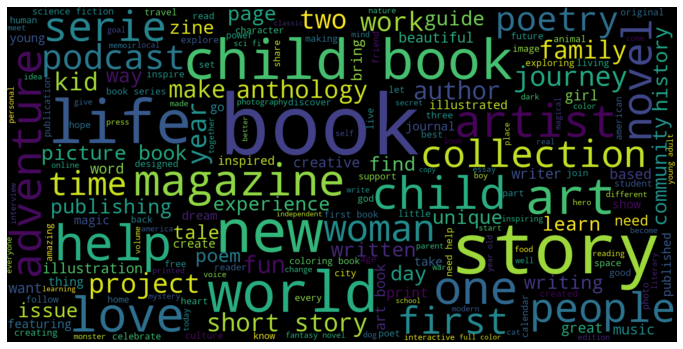

In [110]:
corpus_all = ' '.join(publishing_df['blurb_corpus'])

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(corpus_all)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 300 words')

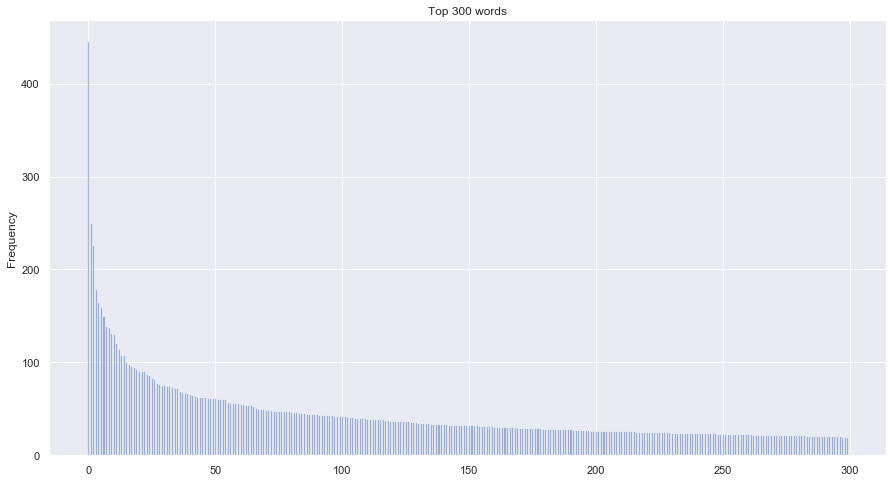

In [111]:
y_pos = np.arange(300)
plt.figure(figsize=(15,8))
plt.bar(y_pos, uni_ranking.sort_values(by='rank', ascending=False)['rank'][:300], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 300 words')

## c) Train/Test Split

In [112]:
msk = np.random.rand(len(publishing_df)) < 0.75

train_df = publishing_df[msk]
test_df = publishing_df[~msk]

In [113]:
print(len(test_df))
print(len(train_df))

3150
9334


In [114]:
#split test into X_test and y_test for later
y_test = test_df['state']
X_test = test_df.drop('state',axis=1)

## d) Resampling

In [115]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(train_df['state'].unique())
train_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(train_df['state'].unique())

['failed' 'successful']
[0 1]


C:\Users\vlad_\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [116]:
#change successful:1 / failed:0 in state column (y-dependent-variable)
print(test_df['state'].unique())
test_df.state.replace(['successful', 'failed'], [1, 0], inplace=True)
print(test_df['state'].unique())

['successful' 'failed']
[1 0]


In [117]:
train_df['state'].value_counts()

1    7535
0    1799
Name: state, dtype: int64

In [118]:
#class count
count_class_1, count_class_0 = train_df.state.value_counts()

#divide by class
df_class_0 = train_df[train_df['state'] == 0]
df_class_1 = train_df[train_df['state'] == 1]

##### i) Random Over-Sampling

Random over-sampling:
1    7535
0    7535
Name: state, dtype: int64


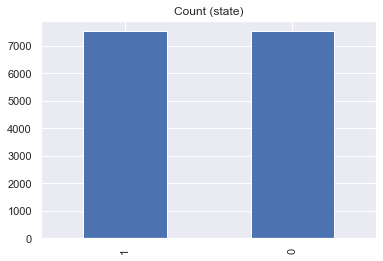

In [119]:
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.state.value_counts())

df_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

##### ii) Random under-sampling

Random under-sampling:
1    1799
0    1799
Name: state, dtype: int64


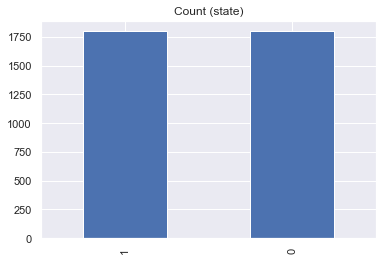

In [120]:
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
df_test_under['state'].value_counts()
print('Random under-sampling:')
print(df_test_under.state.value_counts())

df_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

## e) Classification (Original data, Oversampled data, Undersampled data)

The following lines will include classification algorithms using 3 types of data: the original data with outliers removed, oversampled data, and undersampled data.

### i) Original data

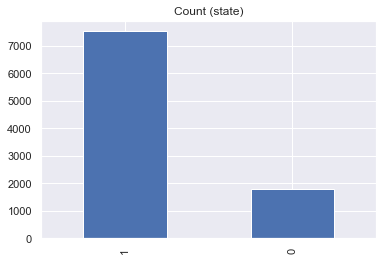

In [121]:
train_df.state.value_counts().plot(kind='bar', title='Count (state)')

In [122]:
#split into X_train and y_train
y_train = train_df['state']
X_train = train_df.drop('state',axis=1)

In [123]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_train['blurb_corpus'])
X_vec_train.shape

(9334, 71857)

In [124]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_tfidf.shape

(9334, 71857)

In [125]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3150, 71857)

In [126]:
#apply TDIDF on test set
test_tfidf = tfidf_transformer.transform(X_vec_test)
test_tfidf.shape

(3150, 71857)

##### Naive Bayes Classifier

In [25]:
#fitting Naive Bayes Classifier to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = nb_classifier.predict(test_tfidf)

Confusion matrix:
 [[   3  587]
 [   2 2556]]


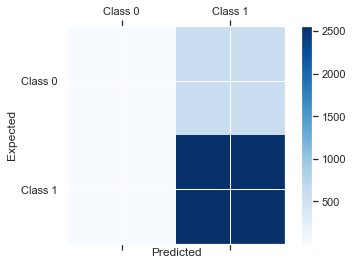

In [26]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [27]:
accText = 'Naive Bayes, Publishing Original'

In [28]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 81.29%
 Precision: 81.32%
    Recall: 99.92%
  F1 score: 89.67%
 ROC score: 50.22%


In [29]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [30]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = reg_classifier.predict(test_tfidf)

Confusion matrix:
 [[   2  588]
 [   6 2552]]


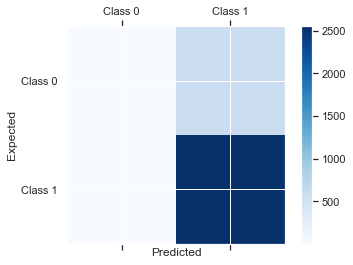

In [31]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [32]:
accText = 'Logistic Regression, Publishing Original'

In [33]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 81.13%
 Precision: 81.27%
    Recall: 99.77%
  F1 score: 89.58%
 ROC score: 50.05%


In [34]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [35]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_tfidf, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 29


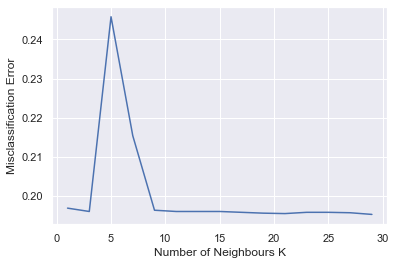

In [36]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [37]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 29, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = knn_classifier.predict(test_tfidf)

Confusion matrix:
 [[  18  572]
 [  13 2545]]


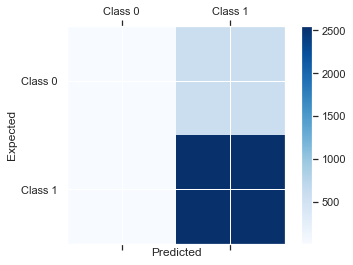

In [38]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [39]:
accText = 'KNN, Publishing Original'

In [40]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 81.42%
 Precision: 81.65%
    Recall: 99.49%
  F1 score: 89.69%
 ROC score: 51.27%


In [41]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [42]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_tfidf, y_train)

#predicting the test set results
predictions = svm_classifier.predict(test_tfidf)

Confusion matrix:
 [[ 165  425]
 [ 337 2221]]


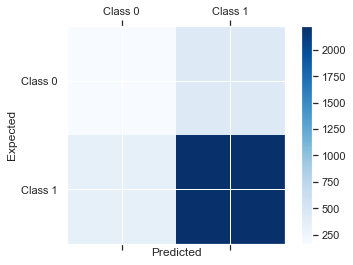

In [43]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [44]:
accText = 'SVM, Publishing Original'

In [45]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 75.79%
 Precision: 83.94%
    Recall: 86.83%
  F1 score: 85.36%
 ROC score: 57.40%


In [46]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### ii) Over-sampled data

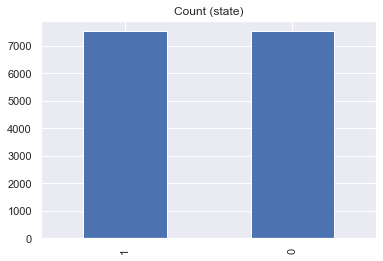

In [127]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.state.value_counts().plot(kind='bar', title='Count (state)')

In [128]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('state',axis=1)
y_over_train = df2_test_over['state']

In [129]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_over_train['blurb_corpus'])
X_vec_train.shape

(15070, 71684)

In [130]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_over_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_over_tfidf.shape

(15070, 71684)

In [131]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3150, 71684)

In [132]:
#apply TDIDF on test set
test_over_tfidf = tfidf_transformer.transform(X_vec_test)
test_over_tfidf.shape

(3150, 71684)

##### Naive Bayes Classifier

In [133]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 330  291]
 [ 783 1746]]


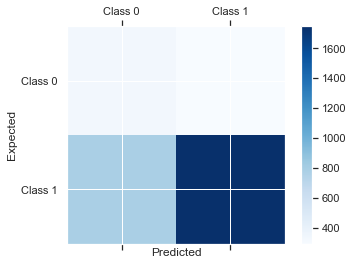

In [134]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [135]:
accText = 'Naive Bayes, Publishing Oversampling'

In [136]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 65.90%
 Precision: 85.71%
    Recall: 69.04%
  F1 score: 76.48%
 ROC score: 61.09%


In [137]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier

In [138]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = reg_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 121  500]
 [ 207 2322]]


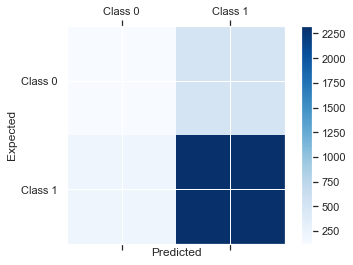

In [139]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [140]:
accText = 'Logistic Regression, Publishing Oversampling'

In [141]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 77.56%
 Precision: 82.28%
    Recall: 91.81%
  F1 score: 86.79%
 ROC score: 55.65%


In [142]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [63]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_over_tfidf, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 5


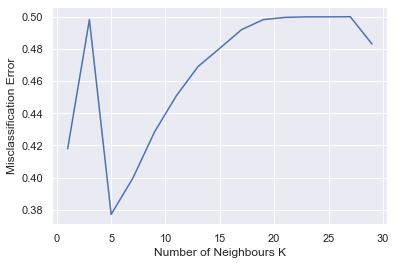

In [64]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [65]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 246  344]
 [ 693 1865]]


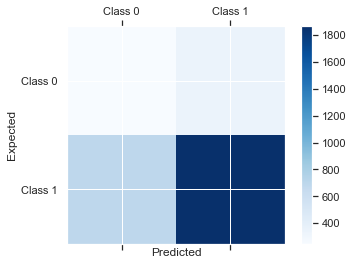

In [66]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [67]:
accText = 'KNN, Publishing Oversampling'

In [68]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 67.06%
 Precision: 84.43%
    Recall: 72.91%
  F1 score: 78.25%
 ROC score: 57.30%


In [69]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [143]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[ 118  503]
 [ 205 2324]]


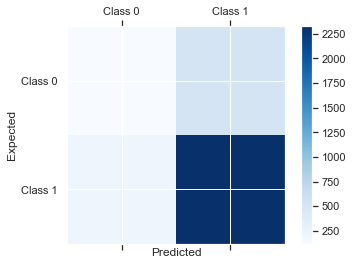

In [144]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [145]:
accText = 'SVM, Publishing Oversampling'

In [146]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 77.52%
 Precision: 82.21%
    Recall: 91.89%
  F1 score: 86.78%
 ROC score: 55.45%


In [147]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

### iii) Under-sampled data

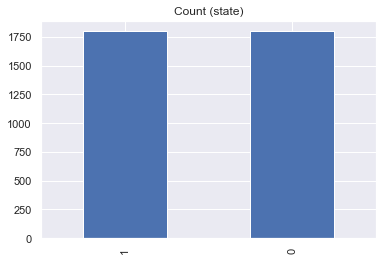

In [148]:
df2_test_under = pd.DataFrame(df_test_under)
df2_test_under.state.value_counts().plot(kind='bar', title='Count (state)')

In [149]:
#split into X_train and y_train
X_under_train = df2_test_under.drop('state',axis=1)
y_under_train = df2_test_under['state']

In [150]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_under_train['blurb_corpus'])
X_vec_train.shape

(3598, 31257)

In [151]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_under_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_under_tfidf.shape

(3598, 31257)

In [152]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['blurb_corpus'])
X_vec_test.shape

(3150, 31257)

In [153]:
#apply TDIDF on test set
test_under_tfidf = tfidf_transformer.transform(X_vec_test)
test_under_tfidf.shape

(3150, 31257)

##### Naive Bayes Classifier

In [154]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = nb_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 408  213]
 [1225 1304]]


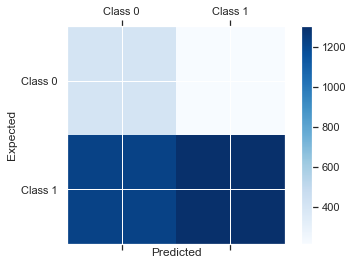

In [155]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [156]:
accText = 'Naive Bayes, Publishing Undersampling'

In [157]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 54.35%
 Precision: 85.96%
    Recall: 51.56%
  F1 score: 64.46%
 ROC score: 58.63%


In [158]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### Logistic Regression Classifier


In [159]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'saga')
reg_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = reg_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 436  185]
 [1339 1190]]


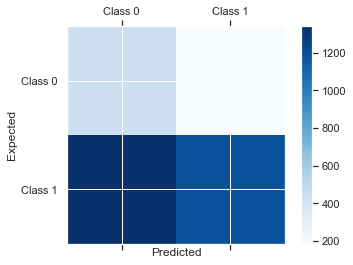

In [160]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [161]:
accText = 'Logistic Regression, Publishing Undersampling'

In [162]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 51.62%
 Precision: 86.55%
    Recall: 47.05%
  F1 score: 60.96%
 ROC score: 58.63%


In [163]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### KNN Classifier

In [91]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 30, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_under_tfidf, y_under_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 25


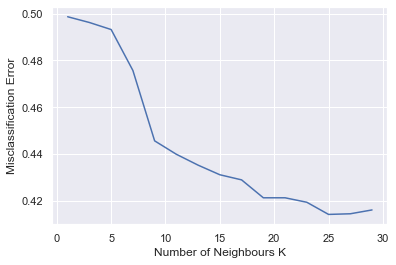

In [92]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [93]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 25, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
prediction = knn_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 538   52]
 [1918  640]]


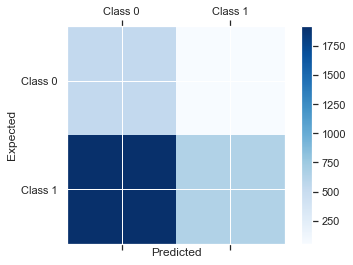

In [94]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=prediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [95]:
accText = 'KNN, Publishing Undersampling'

In [96]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 52.73%
 Precision: 89.22%
    Recall: 47.58%
  F1 score: 62.06%
 ROC score: 61.33%


In [97]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

##### SVM Classifier

In [164]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='log', penalty='l2')
svm_classifier.fit(train_under_tfidf, y_under_train)

#predicting the test set results
predictions = svm_classifier.predict(test_under_tfidf)

Confusion matrix:
 [[ 429  192]
 [1305 1224]]


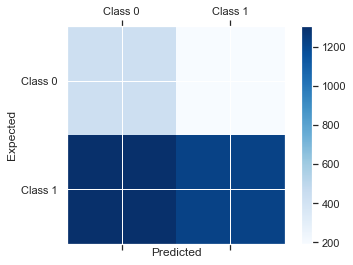

In [165]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [166]:
accText = 'SVM, Publishing Undersampling'

In [167]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 52.48%
 Precision: 86.44%
    Recall: 48.40%
  F1 score: 62.05%
 ROC score: 58.74%


In [168]:
acc = pd.read_csv("accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.at[accText, 'ROC'] = (roc_auc)
acc.to_csv("accuracies.csv")

## End of Step 6(c)